In [549]:
import numpy as np
import pickle
#from tqdm import tqdm # type: ignore
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
#from torchvision import datasets, transforms # type: ignore
from scipy.special import softmax

In [550]:
# 1. Dense Layer (Fully Connected Layer)
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / input_dim)
        self.biases = np.zeros((1, output_dim))
    
    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.biases
    
    def backward(self, grad_output, learning_rate):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        
        self.weights -= learning_rate * grad_weights
        self.biases -= learning_rate * grad_biases
        
        return grad_input

In [551]:
# 2. Batch Normalization Layer
class BatchNormalization:
    def __init__(self, dim, epsilon=1e-8):
        self.gamma = np.ones((1, dim))
        self.beta = np.zeros((1, dim))
        self.epsilon = epsilon

    def forward(self, x):
        self.mean = x.mean(axis=0)
        self.variance = x.var(axis=0)
        self.x_normalized = (x - self.mean) / np.sqrt(self.variance + self.epsilon)
        return self.gamma * self.x_normalized + self.beta

    def backward(self, grad_output, learning_rate):
        
        grad_input = grad_output * self.gamma / np.sqrt(self.variance + self.epsilon)
        self.gamma -= learning_rate * np.sum(grad_output * self.x_normalized, axis=0)
        self.beta -= learning_rate * np.sum(grad_output, axis=0)
        return grad_input


In [552]:
# 3. ReLU Activation Function
class ReLU:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)
    
    def backward(self, grad_output):
        grad_input = grad_output * (self.input > 0)
        return grad_input

In [553]:
# 4. Dropout Regularization
class Dropout:
    def __init__(self, drop_prob):
        self.drop_prob = drop_prob
    
    def forward(self, x, training=True):
        if training:
            self.mask = np.random.binomial(1, 1 - self.drop_prob, size=x.shape)
            return x * self.mask / (1 - self.drop_prob)
        return x
    
    def backward(self, grad_output):
        return grad_output * self.mask

In [554]:
class NeuralNetwork:
    def __init__(self, architecture, learning_rate=0.0005, dropout_rate=0.5):
        self.layers = []
        self.learning_rate = learning_rate
        for layer_info in architecture:
            if layer_info["type"] == "dense":
                self.layers.append(DenseLayer(layer_info["input_dim"], layer_info["output_dim"]))
            elif layer_info["type"] == "batch_norm":
                self.layers.append(BatchNormalization(layer_info["dim"]))
            elif layer_info["type"] == "activation":
                self.layers.append(ReLU())
            elif layer_info["type"] == "dropout":
                self.layers.append(Dropout(dropout_rate))
    
    def forward(self, x, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, training)
            else:
                x = layer.forward(x)
        return x
    
    def backward(self, grad_output):
        for layer in reversed(self.layers):
            
            if isinstance(layer, (DenseLayer, BatchNormalization)):
                grad_output = layer.backward(grad_output, self.learning_rate)
            else:
                grad_output = layer.backward(grad_output)


In [555]:
# Helper functions
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]


In [556]:
import torch
from torchvision import datasets, transforms

def load_data(batch_size=64):
    
    transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])



    train_data = datasets.FashionMNIST(root=".", train=True, download=True, transform=transform)
    test_data = datasets.FashionMNIST(root=".", train=False, download=True, transform=transform)
    
    return train_data, test_data


In [557]:
initial_learning_rate = 0.001
learning_rate_decay = 0.95  


In [558]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_data))  # type: ignore # 80% for training
val_size = len(train_data) - train_size  # type: ignore # 20% for validation
train_data, val_data = random_split(train_data, [train_size, val_size]) # type: ignore


In [559]:
from sklearn.metrics import f1_score

def train(model, train_data, val_data, epochs, batch_size):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    val_macro_f1s = []

    for epoch in range(epochs):
        
        model.learning_rate = model.learning_rate * 0.95  
        epoch_loss, correct_predictions, total_samples = 0, 0, 0
        for i in range(0, len(train_data), batch_size):
            x_batch, y_batch = get_batch(train_data, i, batch_size) # type: ignore
            predictions = model.forward(x_batch)
            
            loss = calculate_loss(predictions, y_batch) # type: ignore
            epoch_loss += loss * len(y_batch)
            batch_predictions = np.argmax(predictions, axis=1)
            correct_predictions += np.sum(batch_predictions == y_batch)
            total_samples += len(y_batch)
            
            grad_output = calculate_grad_loss(predictions, y_batch) # type: ignore
            model.backward(grad_output)
        
        avg_train_loss = epoch_loss / total_samples
        avg_train_accuracy = correct_predictions / total_samples
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        

        # Validation Phase
        val_loss, val_correct, val_total = 0, 0, 0
        all_val_predictions, all_val_targets = [], []
        for i in range(0, len(val_data), batch_size):
            x_val_batch, y_val_batch = get_batch(val_data, i, batch_size) # type: ignore
            val_predictions = model.forward(x_val_batch, training=False)
            
            val_loss += calculate_loss(val_predictions, y_val_batch) * len(y_val_batch) # type: ignore
            batch_val_predictions = np.argmax(val_predictions, axis=1)
            val_correct += np.sum(batch_val_predictions == y_val_batch)
            val_total += len(y_val_batch)
            
            all_val_predictions.extend(batch_val_predictions)
            all_val_targets.extend(y_val_batch)
        
        avg_val_loss = val_loss / val_total
        avg_val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        # Calculating macro F1 score for validation set
        macro_f1 = f1_score(all_val_targets, all_val_predictions, average='macro')
        val_macro_f1s.append(macro_f1)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}, Validation Macro F1: {macro_f1:.4f}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies, val_macro_f1s


In [560]:
# Main function to build and run the network
if __name__ == "__main__":
    
    architecture = [
    {"type": "dense", "input_dim": 784, "output_dim": 256},
    {"type": "batch_norm", "dim": 256},
    {"type": "activation"},
    {"type": "dropout"},
    {"type": "dense", "input_dim": 256, "output_dim": 128},
    {"type": "batch_norm", "dim": 128},
    {"type": "activation"},
    {"type": "dropout"},
    {"type": "dense", "input_dim": 128, "output_dim": 10}
    ]


    
    model = NeuralNetwork(architecture, learning_rate=0.005, dropout_rate=0.1)
    train_data, test_data = load_data()
    epochs = 20
    batch_size = 64
    

In [561]:
# Calculate Cross-Entropy Loss
def calculate_loss(predictions, targets):
    predictions = softmax(predictions, axis=1)
    log_likelihood = -np.log(predictions[range(targets.shape[0]), targets])
    loss = np.sum(log_likelihood) / targets.shape[0]
    return loss

# Accuracy calculation
def calculate_accuracy(predictions, targets):
    predictions = np.argmax(predictions, axis=1)
    accuracy = np.mean(predictions == targets)
    return accuracy

# Gradient of loss with respect to predictions
def calculate_grad_loss(predictions, targets):
    m = targets.shape[0]
    grad_output = softmax(predictions, axis=1)
    grad_output[range(m), targets] -= 1
    grad_output /= m
    return grad_output

# Batch processing function
def get_batch(dataset, start_idx, batch_size):
    images, labels = [], []
    for i in range(start_idx, start_idx + batch_size):
        if i >= len(dataset):
            break
        image, label = dataset[i]
        images.append(image.numpy().reshape(-1))  
        labels.append(label)
    return np.array(images), np.array(labels)


In [ ]:
# Training
train_losses, val_losses, train_accuracies, val_accuracies, val_macro_f1s = train(model, train_data, val_data, epochs, batch_size)


# Save the model
with open("model_weights.pkl", "wb") as f:
    pickle.dump(model, f)

Epoch 1/20, Train Loss: 1.0663, Train Accuracy: 0.6353
Validation Loss: 0.7576, Validation Accuracy: 0.7341, Validation Macro F1: 0.7286
Epoch 2/20, Train Loss: 0.7629, Train Accuracy: 0.7315
Validation Loss: 0.6708, Validation Accuracy: 0.7613, Validation Macro F1: 0.7566
Epoch 3/20, Train Loss: 0.6942, Train Accuracy: 0.7559
Validation Loss: 0.6281, Validation Accuracy: 0.7742, Validation Macro F1: 0.7703
Epoch 4/20, Train Loss: 0.6591, Train Accuracy: 0.7647
Validation Loss: 0.5981, Validation Accuracy: 0.7861, Validation Macro F1: 0.7823
Epoch 5/20, Train Loss: 0.6304, Train Accuracy: 0.7743
Validation Loss: 0.5801, Validation Accuracy: 0.7903, Validation Macro F1: 0.7867
Epoch 6/20, Train Loss: 0.6099, Train Accuracy: 0.7825
Validation Loss: 0.5638, Validation Accuracy: 0.7982, Validation Macro F1: 0.7951
Epoch 7/20, Train Loss: 0.5969, Train Accuracy: 0.7859
Validation Loss: 0.5522, Validation Accuracy: 0.8001, Validation Macro F1: 0.7973
Epoch 8/20, Train Loss: 0.5833, Train Acc

In [525]:
# Evaluation on test data
def evaluate(model, test_data, batch_size=64):
    all_predictions, all_targets = [], []
    total_loss, total_accuracy = 0, 0

    for i in range(0, len(test_data), batch_size):
        x_batch, y_batch = get_batch(test_data, i, batch_size)
        predictions = model.forward(x_batch, training=False)
        
        total_loss += calculate_loss(predictions, y_batch)
        total_accuracy += calculate_accuracy(predictions, y_batch)
        
        all_predictions.extend(np.argmax(predictions, axis=1))
        all_targets.extend(y_batch)
    
    avg_loss = total_loss / (len(test_data) / batch_size)
    avg_accuracy = total_accuracy / (len(test_data) / batch_size)
    
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}")
    return np.array(all_predictions), np.array(all_targets), avg_loss, avg_accuracy


In [526]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix and classification report
def generate_metrics(predictions, targets):
    conf_matrix = confusion_matrix(targets, predictions)
    class_report = classification_report(targets, predictions, target_names=[
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
        "Shirt", "Sneaker", "Bag", "Ankle boot"
    ])
    
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    return conf_matrix, class_report


In [527]:
print("Number of epochs:", epochs)
print("Recorded losses:", len(losses)) # type: ignore
print("Recorded accuracies:", len(accuracies)) # type: ignore


Number of epochs: 20
Recorded losses: 10
Recorded accuracies: 10


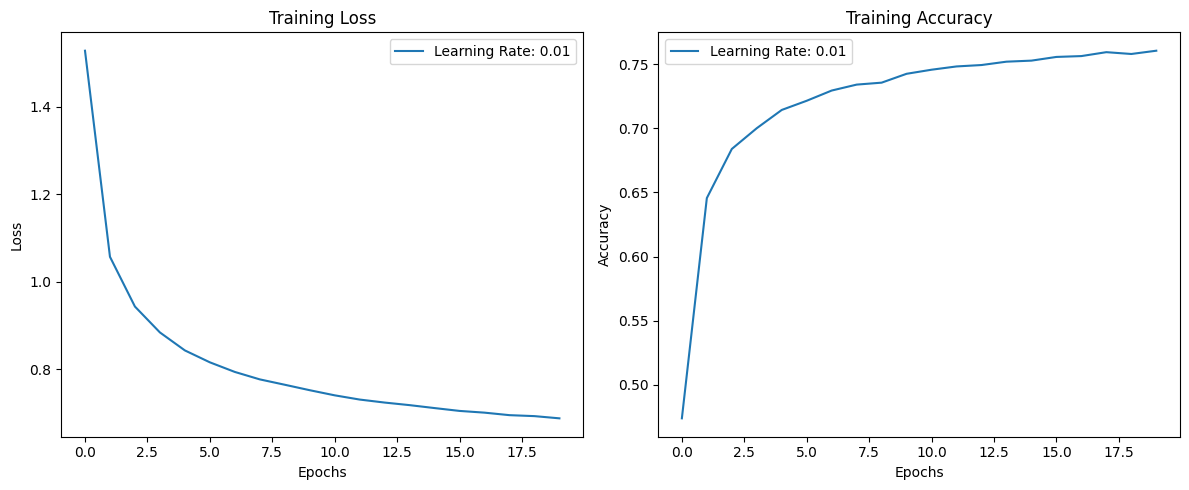

In [528]:
def plot_training_curves(losses, accuracies, learning_rate):
    epochs = len(losses)  # Use the length of losses to ensure consistency

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), losses, label=f'Learning Rate: {learning_rate}')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracies, label=f'Learning Rate: {learning_rate}')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Example usage after training with different learning rates
plot_training_curves(train_losses, train_accuracies, learning_rate=0.01) # type: ignore

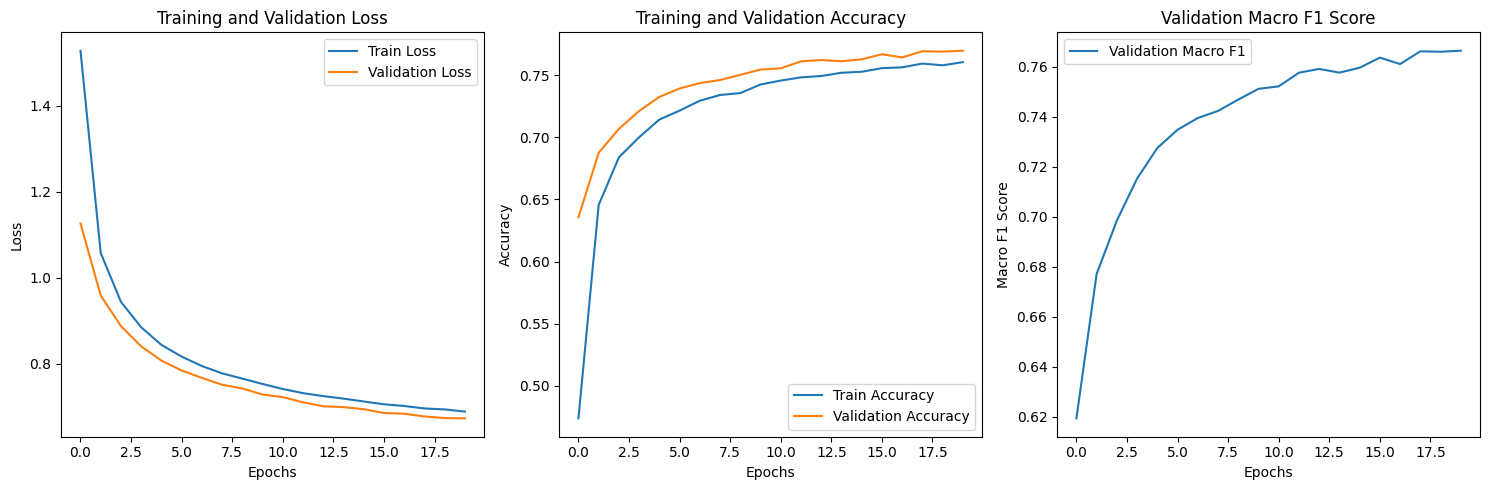

In [529]:
import matplotlib.pyplot as plt

def plot_metrics(epochs, train_losses, val_losses, train_accuracies, val_accuracies, val_macro_f1s):
    plt.figure(figsize=(15, 5))

    # Plotting Training and Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    # Plotting Validation Macro F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(range(epochs), val_macro_f1s, label='Validation Macro F1')
    plt.xlabel("Epochs")
    plt.ylabel("Macro F1 Score")
    plt.title("Validation Macro F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()


epochs = 20
plot_metrics(epochs, train_losses, val_losses, train_accuracies, val_accuracies, val_macro_f1s)


In [530]:
# Saving the best model
with open("model_weights_best.pkl", "wb") as f:
    pickle.dump(model, f)

# Saving evaluation metrics to a file
def save_report(conf_matrix, class_report, avg_loss, avg_accuracy):
    with open("report.txt", "w") as f:
        f.write("Confusion Matrix:\n")
        f.write(str(conf_matrix) + "\n\n")
        f.write("Classification Report:\n")
        f.write(class_report + "\n\n")
        f.write(f"Test Loss: {avg_loss:.4f}\n")
        f.write(f"Test Accuracy: {avg_accuracy:.4f}\n")



In [531]:

predictions, targets, avg_loss, avg_accuracy = evaluate(model, test_data)

# Generate metrics and save the report
conf_matrix, class_report = generate_metrics(predictions, targets)



Test Loss: 0.6941, Test Accuracy: 0.7640
Confusion Matrix:
 [[756   9  22  80   5  16  91   1  20   0]
 [ 16 905  12  48  12   1   5   0   1   0]
 [ 11   3 649  11 171  29 107   0  19   0]
 [ 36  18  17 826  35   7  57   0   4   0]
 [  0   6 134  47 690   4 109   0  10   0]
 [  2   2   0   1   0 786   3 126   9  71]
 [183   6 145  69 142  31 390   1  32   1]
 [  0   0   0   0   0  82   0 829   3  86]
 [  1   3  15  12   3  62  18  21 861   4]
 [  0   0   0   1   0  34   4  50   5 906]]

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.75      0.76      0.75      1000
     Trouser       0.95      0.91      0.93      1000
    Pullover       0.65      0.65      0.65      1000
       Dress       0.75      0.83      0.79      1000
        Coat       0.65      0.69      0.67      1000
      Sandal       0.75      0.79      0.77      1000
       Shirt       0.50      0.39      0.44      1000
     Sneaker       0.81      0.83      0.82      10

In [532]:
# After generating the metrics
conf_matrix, class_report = generate_metrics(predictions, targets) # type: ignore

Confusion Matrix:
 [[756   9  22  80   5  16  91   1  20   0]
 [ 16 905  12  48  12   1   5   0   1   0]
 [ 11   3 649  11 171  29 107   0  19   0]
 [ 36  18  17 826  35   7  57   0   4   0]
 [  0   6 134  47 690   4 109   0  10   0]
 [  2   2   0   1   0 786   3 126   9  71]
 [183   6 145  69 142  31 390   1  32   1]
 [  0   0   0   0   0  82   0 829   3  86]
 [  1   3  15  12   3  62  18  21 861   4]
 [  0   0   0   1   0  34   4  50   5 906]]

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.75      0.76      0.75      1000
     Trouser       0.95      0.91      0.93      1000
    Pullover       0.65      0.65      0.65      1000
       Dress       0.75      0.83      0.79      1000
        Coat       0.65      0.69      0.67      1000
      Sandal       0.75      0.79      0.77      1000
       Shirt       0.50      0.39      0.44      1000
     Sneaker       0.81      0.83      0.82      1000
         Bag       0.89      0.86     

In [533]:
save_report(conf_matrix, class_report, avg_loss, avg_accuracy)

Test Loss: 0.6930, Test Accuracy: 0.7627


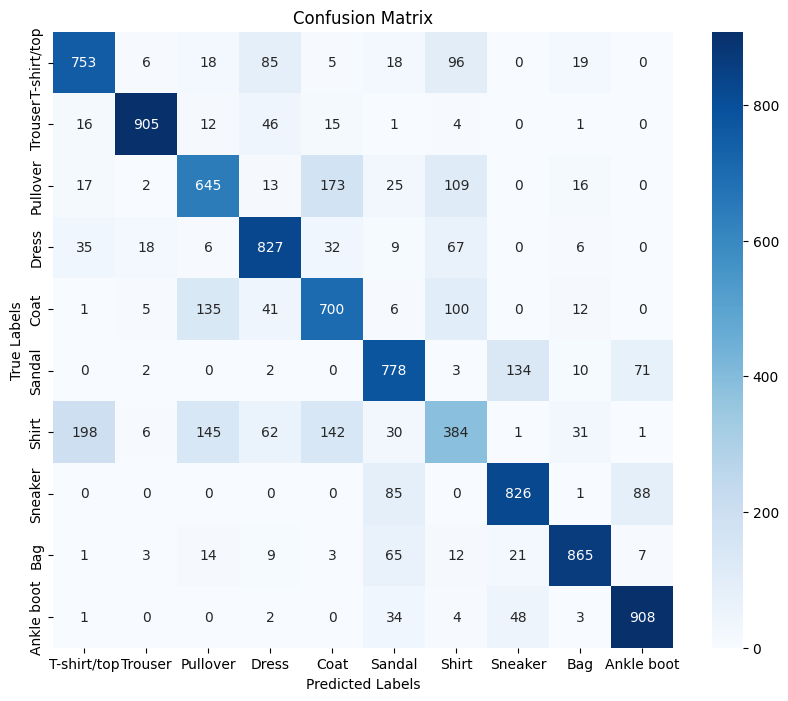

In [534]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix function
def plot_confusion_matrix(predictions, targets, class_names):
    conf_matrix = confusion_matrix(targets, predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
               "Shirt", "Sneaker", "Bag", "Ankle boot"]


predictions, targets, avg_loss, avg_accuracy = evaluate(model, test_data)

# Plot the confusion matrix
plot_confusion_matrix(predictions, targets, class_names)
